![]()

# Kannada MNIST

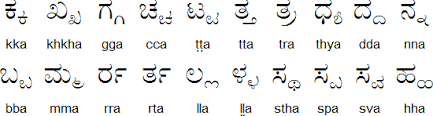

# 1. Import 

In [ ]:
# System
import sys
import os
import argparse
import itertools

# Time
import time
import datetime

# Numerical Data
import random
import numpy as np 
import pandas as pd

# Tools
import shutil
from glob import glob
from tqdm import tqdm
import gc

# NLP
import re

# Preprocessing
from sklearn import preprocessing
from sklearn.utils import class_weight as cw
from sklearn.utils import shuffle

# Model Selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# Machine Learning Models
from sklearn import svm
from sklearn.svm import LinearSVC, SVC

# Evaluation Metrics
from sklearn import metrics 
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, roc_auc_score


# Deep Learning - Keras -  Preprocessing
from keras.preprocessing.image import ImageDataGenerator

# Deep Learning - Keras - Model
import keras
from keras import models
from keras.models import Model
from keras.models import load_model
from keras.models import Sequential

# Deep Learning - Keras - Layers
from keras.layers import Convolution1D, concatenate, SpatialDropout1D, GlobalMaxPool1D, GlobalAvgPool1D, Embedding, \
    Conv2D, SeparableConv1D, Add, BatchNormalization, Activation, GlobalAveragePooling2D, LeakyReLU, Flatten
from keras.layers import Dense, Input, Dropout, MaxPool2D, MaxPooling2D, Concatenate, GlobalMaxPooling2D, GlobalAveragePooling2D, \
    Lambda, Multiply, LSTM, Bidirectional, PReLU, MaxPooling1D
from keras.layers.pooling import _GlobalPooling1D

from keras.regularizers import l2

# Deep Learning - Keras - Pretrained Models
from keras.applications.xception import Xception
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.densenet import DenseNet201
from keras.applications.nasnet import NASNetMobile, NASNetLarge

from keras.applications.nasnet import preprocess_input

# Deep Learning - Keras - Model Parameters and Evaluation Metrics
from keras import optimizers
from keras.optimizers import Adam, SGD , RMSprop
from keras.losses import mae, sparse_categorical_crossentropy, binary_crossentropy

# Deep Learning - Keras - Visualisation
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau, LearningRateScheduler
# from keras.wrappers.scikit_learn import KerasClassifier
from keras import backend as K

# Deep Learning - TensorFlow
import tensorflow as tf

# Graph/ Visualization
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.image as mpimg
import seaborn as sns
from mlxtend.plotting import plot_confusion_matrix

# Image
import cv2
from PIL import Image
from IPython.display import display

# np.random.seed(42)

%matplotlib inline

# Input data
print(os.listdir("../input/"))

# 2. Functions

In [ ]:
def date_time(x):
    if x==1:
        return 'Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now())
    if x==2:    
        return 'Timestamp: {:%Y-%b-%d %H:%M:%S}'.format(datetime.datetime.now())
    if x==3:  
        return 'Date now: %s' % datetime.datetime.now()
    if x==4:  
        return 'Date today: %s' % datetime.date.today()  

# 3. Input Configuration

In [ ]:
input_directory = r"../input/Kannada-MNIST/"
output_directory = r"../output/"

training_dir = input_directory + "train_images"
testing_dir = input_directory + r"test_images"

if not os.path.exists(output_directory):
    os.mkdir(output_directory)
    
figure_directory = "../output/figures"
if not os.path.exists(figure_directory):
    os.mkdir(figure_directory)

# model_input_directory = "../input/models/"
# if not os.path.exists(model_input_directory):
#     os.mkdir(model_input_directory)

model_output_directory = "../output/models/"
if not os.path.exists(model_output_directory):
    os.mkdir(model_output_directory)


    
file_name_pred_batch = figure_directory+r"/result"
file_name_pred_sample = figure_directory+r"/sample"

In [ ]:
train_df = pd.read_csv(input_directory + "train.csv")
train_df.rename(index=str, columns={"label": "target"}, inplace=True)
train_df.head()

In [ ]:
test_df = pd.read_csv(input_directory + "test.csv")
test_df.rename(index=str, columns={"label": "target"}, inplace=True)
test_df.head()

# 4. Visualization

In [ ]:
ticksize = 18
titlesize = ticksize + 8
labelsize = ticksize + 5

figsize = (18, 5)
params = {'figure.figsize' : figsize,
          'axes.labelsize' : labelsize,
          'axes.titlesize' : titlesize,
          'xtick.labelsize': ticksize,
          'ytick.labelsize': ticksize}

plt.rcParams.update(params)

col = "target"
xlabel = "Label"
ylabel = "Count"

sns.countplot(x=train_df[col])
plt.title("Label Count")
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.show()

# 5. Preprocess

In [ ]:
def get_data(train_X=None, train_Y=None, test_X=None, batch_size=32):
    print("Preprocessing and Generating Data Batches.......\n")
    
    rescale = 1.0/255

    train_batch_size = batch_size
    validation_batch_size = batch_size*5
    test_batch_size = batch_size*5
    
    train_shuffle = True
    val_shuffle = True
    test_shuffle = False
    
    train_datagen = ImageDataGenerator(
        horizontal_flip=False,
        vertical_flip=False,
        rotation_range=10,
#         shear_range=15,
        zoom_range = 0.1, 
        width_shift_range=0.1,  
        height_shift_range=0.1,
        rescale=rescale,
        validation_split=0.25)

    
    train_generator = train_datagen.flow(
        x=train_X, 
        y=train_Y, 
        batch_size=batch_size,
        shuffle=True, 
        sample_weight=None, 
        seed=42, 
        save_to_dir=None, 
        save_prefix='', 
        save_format='png', 
        subset='training')
    
    
    validation_generator = train_datagen.flow(
        x=train_X, 
        y=train_Y, 
        batch_size=validation_batch_size,
        shuffle=True, 
        sample_weight=None, 
        seed=42, 
        save_to_dir=None, 
        save_prefix='', 
        save_format='png', 
        subset='validation')
    
    test_datagen = ImageDataGenerator(rescale=rescale)
    
    test_generator = test_datagen.flow(
        x=test_X, 
        y=None,  
        batch_size=test_batch_size,
        shuffle=False, 
        sample_weight=None, 
        seed=42, 
        save_to_dir=None, 
        save_prefix='', 
        save_format='png')
    
    class_weights = get_weight(np.argmax(train_Y, axis=1))
    
    steps_per_epoch = len(train_generator)
    validation_steps = len(validation_generator)
    
    print("\nPreprocessing and Data Batch Generation Completed.\n")
    
    
    return train_generator, validation_generator, test_generator, class_weights, steps_per_epoch, validation_steps
            
# Calculate Class Weights
def get_weight(y):
    class_weight_current =  cw.compute_class_weight('balanced', np.unique(y), y)
    return class_weight_current

# 5. Model Function

In [ ]:
def get_model(model_name, input_shape=(96, 96, 3), num_class=2, weights='imagenet', dense_units=1024, internet=False):
    inputs = Input(input_shape)
    
    if model_name == "Xception":
        base_model = Xception(include_top=False, weights=weights, input_shape=input_shape)
    elif model_name == "ResNet50":
        base_model = ResNet50(include_top=False, weights=weights, input_shape=input_shape)
    elif model_name == "ResNet101":
        base_model = keras.applications.resnet.ResNet101(include_top=False, weights=weights, input_shape=input_shape)
    elif model_name == "ResNet152":
        base_model = keras.applications.resnet.ResNet152(include_top=False, weights=weights, input_shape=input_shape)
    elif model_name == "ResNet50V2":
        base_model = resnet_v2.ResNet50V2(include_top=False, weights=weights, input_shape=input_shape)
    elif model_name == "ResNet101V2":
        base_model = resnet_v2.ResNet101V2(include_top=False, weights=weights, input_shape=input_shape)
    elif model_name == "ResNet152V2":
        base_model = resnet_v2.ResNet152V2(include_top=False, weights=weights, input_shape=input_shape)
    elif model_name == "ResNeXt50":
        base_model = resnext.ResNeXt50(include_top=False, weights=weights, input_shape=input_shape)
    elif model_name == "ResNeXt101":
        base_model = resnext.ResNeXt101(include_top=False, weights=weights, input_shape=input_shape)
    elif model_name == "InceptionV3":
        base_model = InceptionV3(include_top=False, weights=weights, input_shape=input_shape)
    elif model_name == "InceptionResNetV2":
        base_model = InceptionResNetV2(include_top=False, weights=weights, input_shape=input_shape)
    elif model_name == "DenseNet201":
        base_model = DenseNet201(include_top=False, weights=weights, input_shape=input_shape)
    elif model_name == "NASNetMobile":
        base_model = NASNetMobile(include_top=False, weights=weights, input_shape=input_shape)
    elif model_name == "NASNetLarge":
        base_model = NASNetLarge(include_top=False, weights=weights, input_shape=input_shape)
        
        
#     x = base_model(inputs)
#     x = Dropout(0.5)(x)
    
#     out1 = GlobalMaxPooling2D()(x)
#     out2 = GlobalAveragePooling2D()(x)
#     out3 = Flatten()(x)
    
#     out = Concatenate(axis=-1)([out1, out2, out3])
    
#     out = Dropout(0.6)(out)
#     out = BatchNormalization()(out)
#     out = Dropout(0.5)(out)
    
#     if num_class>1:
#         out = Dense(num_class, activation="softmax", name="3_")(out)
#     else:
#         out = Dense(1, activation="sigmoid", name="3_")(out)
        
#     model = Model(inputs, out)
#     model = Model(inputs=base_model.input, outputs=outputs)

    
    x = base_model.output
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    x = Dense(dense_units)(x)
    x = BatchNormalization()(x)
    x = Activation(activation='relu')(x)
    x = Dropout(0.5)(x)
    
    if num_class>1:
        outputs = Dense(num_class, activation="softmax")(x)
    else:
        outputs = Dense(1, activation="sigmoid")(x)

    model = Model(inputs=base_model.input, outputs=outputs)
    
    model.summary()
    
    
    return model


def get_conv_model(num_class=2, input_shape=None, dense_units=256):
    model = Sequential()

    model.add(Conv2D(filters = 32, kernel_size = (5,5), padding = 'Same', activation ='relu', input_shape = input_shape))
    model.add(BatchNormalization())
    model.add(Conv2D(filters = 32, kernel_size = (5,5), padding = 'Same', activation ='relu', kernel_regularizer=l2(1e-4)))
    model.add(BatchNormalization())
    
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))


    model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', activation ='relu', kernel_regularizer=l2(1e-4)))
    model.add(BatchNormalization())
    model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', activation ='relu', kernel_regularizer=l2(1e-4)))
    model.add(BatchNormalization())
    
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.25))

    
    model.add(Flatten())
    model.add(Dense(dense_units, activation = "relu"))
    model.add(Dropout(0.5))

    
#     model.add(Conv2D(32, (3, 3), padding='same', use_bias=False, kernel_regularizer=l2(1e-4), input_shape = input_shape))
#     model.add(BatchNormalization())
#     model.add(Activation('relu'))
    
#     model.add(Conv2D(32, (3, 3), padding='same', use_bias=False, kernel_regularizer=l2(1e-4)))
#     model.add(BatchNormalization())
#     model.add(Activation('relu'))
    
#     model.add(MaxPool2D())
#     model.add(Dropout(0.5))

    
#     model.add(Conv2D(64, (3, 3), padding='same', use_bias=False, kernel_regularizer=l2(1e-4)))
#     model.add(BatchNormalization())
#     model.add(Activation('relu'))
    
#     model.add(Conv2D(64, (3, 3), padding='same', use_bias=False, kernel_regularizer=l2(1e-4)))
#     model.add(BatchNormalization())
#     model.add(Activation('relu'))
    
#     model.add(MaxPool2D())
#     model.add(Dropout(0.5))
    
    
#     model.add(GlobalAveragePooling2D())
    
    
    if num_class>1:
        model.add(Dense(num_class, activation='softmax'))
    else:
        model.add(Dense(num_class, activation='sigmoid'))
    
    print(model.summary())

    return model

## Visualization

In [ ]:
def plot_performance(history=None, figure_directory=None):
    xlabel = 'Epoch'
    legends = ['Training', 'Validation']

    ylim_pad = [0.005, 0.005]
    ylim_pad = [0, 0]


    plt.figure(figsize=(20, 5))

    # Plot training & validation Accuracy values

    y1 = history.history['accuracy']
    y2 = history.history['val_accuracy']

    min_y = min(min(y1), min(y2))-ylim_pad[0]
    max_y = max(max(y1), max(y2))+ylim_pad[0]
    
#     min_y = .96
#     max_y = 1


    plt.subplot(121)

    plt.plot(y1)
    plt.plot(y2)

    plt.title('Model Accuracy\n'+date_time(1), fontsize=17)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel('Accuracy', fontsize=15)
    plt.ylim(min_y, max_y)
    plt.legend(legends, loc='upper left')
    plt.grid()


    # Plot training & validation loss values

    y1 = history.history['loss']
    y2 = history.history['val_loss']

    min_y = min(min(y1), min(y2))-ylim_pad[1]
    max_y = max(max(y1), max(y2))+ylim_pad[1]

#     min_y = .1
#     max_y = 0

    plt.subplot(122)

    plt.plot(y1)
    plt.plot(y2)

    plt.title('Model Loss\n'+date_time(1), fontsize=17)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel('Loss', fontsize=15)
    plt.ylim(min_y, max_y)
    plt.legend(legends, loc='upper left')
    plt.grid()
    if figure_directory:
        plt.savefig(figure_directory+"/history")

    plt.show()

# 6. Output Configuration

In [ ]:
main_model_dir = output_directory + r"models_output/"
main_log_dir = output_directory + r"logs/"

try:
    os.mkdir(main_model_dir)
except:
    print("Could not create main model directory")
    
try:
    os.mkdir(main_log_dir)
except:
    print("Could not create main log directory")



model_dir = main_model_dir + time.strftime('%Y-%m-%d %H-%M-%S') + "/"
log_dir = main_log_dir + time.strftime('%Y-%m-%d %H-%M-%S')


try:
    os.mkdir(model_dir)
except:
    print("Could not create model directory")
    
try:
    os.mkdir(log_dir)
except:
    print("Could not create log directory")
    
model_file = model_dir + "{epoch:02d}-val_acc-{val_acc:.2f}-val_loss-{val_loss:.2f}.hdf5"

## 6.2 Call Back Configuration

In [ ]:
print("Settting Callbacks")

def step_decay(epoch, lr):
    # initial_lrate = 1.0 # no longer needed
    lrate = lr
    if epoch==2:
        lrate = 0.0001  
#     lrate = lr * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate


checkpoint = ModelCheckpoint(
    model_file, 
    monitor='val_acc', 
    save_best_only=True)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True)


reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.6,
    patience=2,
    min_lr=0.0000001,
    verbose=1)

learning_rate_scheduler = LearningRateScheduler(step_decay, verbose=1)
# f1_metrics = Metrics()


callbacks = [reduce_lr, early_stopping]
# callbacks = [checkpoint, reduce_lr, early_stopping]
# callbacks = [reduce_lr, early_stopping, f1_metrics]

print("Set Callbacks at ", date_time(1))

# 7. Model

In [ ]:
print("Getting Base Model", date_time(1))

# model_name="InceptionV3"
# model_name="NASNetMobile"

dim = 28

input_shape = (dim, dim, 1)


num_class = len(set(train_df["target"].values))

weights = 'imagenet'
dense_units = 256

internet = True

# model = get_model(model_name=model_name, 
#                   input_shape=input_shape, 
#                   num_class=num_class, 
#                   weights=weights, 
#                   dense_units=dense_units, 
#                   internet=internet)

model = get_conv_model(num_class=num_class, input_shape=input_shape, dense_units=dense_units)
print("Loaded Base Model", date_time(1))

In [ ]:
loss = 'categorical_crossentropy'
# loss = 'binary_crossentropy'
metrics = ['accuracy']
# metrics = [auroc]

# 8. Data

In [ ]:
# train_X = train_df.drop(columns=["target"]).values
# train_Y = train_df["target"].values


# clf = svm.SVC()

# cross_val_score(clf, train_X, train_Y, cv=10, n_jobs=-1, verbose=2)

In [ ]:
train_X = train_df.drop(columns=["target"]).values
train_X = train_X.reshape(train_X.shape[0], dim, dim,1)

train_Y = train_df["target"].values
train_Y = keras.utils.to_categorical(train_Y, 10) 

test_X = test_df.drop(columns=["id"]).values
test_X = test_X.reshape(test_X.shape[0], dim, dim,1)

In [ ]:
batch_size = 128

# class_mode = "categorical"
# class_mode = "binary"

# target_size = (dim, dim)

train_generator, validation_generator, test_generator, class_weights, steps_per_epoch, validation_steps = get_data(train_X=train_X, train_Y=train_Y, test_X=test_X, batch_size=batch_size)


# 9. Training

In [ ]:
print("Starting Trainning ...\n")

start_time = time.time()
print(date_time(1))

# batch_size = 32
# train_generator, validation_generator, test_generator, class_weights, steps_per_epoch, validation_steps = get_data(batch_size=batch_size)

print("\n\nCompliling Model ...\n")
learning_rate = 0.001
optimizer = Adam(learning_rate)
# optimizer = Adam()

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

steps_per_epoch = len(train_generator)
validation_steps = len(validation_generator)

verbose = 1
epochs = 100

print("Trainning Model ...\n")
history = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    verbose=verbose,
    callbacks=callbacks,
    validation_data=validation_generator,
    validation_steps=validation_steps, 
    class_weight=class_weights)

elapsed_time = time.time() - start_time
elapsed_time = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))

print("\nElapsed Time: " + elapsed_time)
print("Completed Model Trainning", date_time(1))

# 10. Model Performance 
Model Performance  Visualization over the Epochs

In [ ]:
plot_performance(history=history)

In [ ]:
ypreds = model.predict_generator(generator=test_generator, steps = len(test_generator),  verbose=1)
# ypreds

In [ ]:
# ypred = ypreds[:,1]#
ypred = np.argmax(ypreds, axis=1)

In [ ]:
sample_df = pd.read_csv(input_directory+"sample_submission.csv")
sample_df.head()

In [ ]:
test_gen_id = test_generator.index_array
sample_submission_id = sample_df["id"]

len(test_gen_id), len(sample_submission_id)

In [ ]:
sample_list = list(sample_df.id)

pred_dict = dict((key, value) for (key, value) in zip(test_generator.index_array, ypred))

pred_list_new = [pred_dict[f] for f in sample_list]

test_df = pd.DataFrame({'id': sample_list,'label': pred_list_new})

test_df.to_csv('submission.csv', header=True, index=False)

In [ ]:
test_df.head()